In [19]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import os
import xarray as xr
# import cftime
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
# import xesmf as xe
from pathlib import Path
import glob
from data_locations import LOC_FORECASTS_SI, LOC_OBSERVATIONS_SI
from preprocessing import align_data_and_targets, create_mask
from preprocessing import AnomaliesScaler_v1, Standardizer, PreprocessingPipeline
import numpy as np
from numpy import meshgrid, deg2rad, gradient, sin, cos
from xarray import DataArray
import xarray as xr
import rioxarray


In [20]:
data_dir_forecast = LOC_FORECASTS_SI
data_dir_obs = glob.glob(LOC_OBSERVATIONS_SI+ '/NASA*1x1*.nc')[0]


In [66]:
def edit_coords(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby('lon')
    ds = ds.rio.write_crs("EPSG:4326")
    return ds.rename({'lat':'y', 'lon':'x'})

def proj(ds, target_crs = 'EPSG:3413', resolution = 26450):
    ds =  ds.rio.reproject(target_crs,resolution=resolution)
    return ds.where(ds < 1e10, np.nan)[...,:432,:]



## Obs

In [67]:
obs_in = xr.open_dataset(data_dir_obs)['SICN']
obs_in = obs_in.clip(0,1)
obs_in = obs_in.where(obs_in.lat > 40, drop = True)


In [68]:
obs_in = edit_coords(obs_in)
obs_projected = proj(obs_in).drop('spatial_ref').to_dataset()

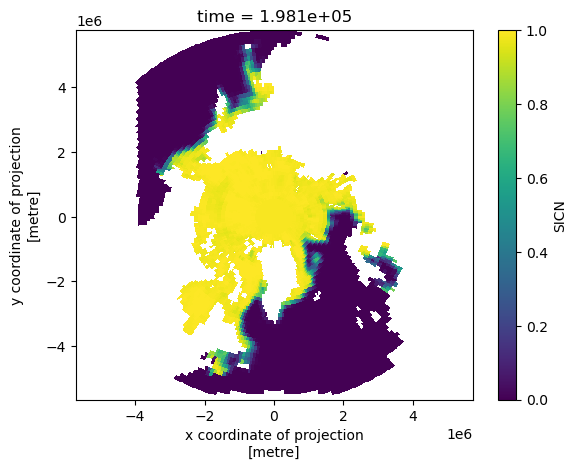

In [69]:
obs_projected['SICN'][0].plot()

In [70]:
obs_in = xr.open_dataset(data_dir_obs)['SICN']
obs_in = obs_in.clip(0,1)
obs_in = obs_in.where(obs_in.lat > 40, drop = True)
mask = edit_coords(xr.ones_like(obs_in[0]))
mask_projected = proj(mask).drop(['time','spatial_ref']).to_dataset(name = 'mask').fillna(0)


In [73]:
xr.combine_by_coords([obs_projected, mask_projected]).to_netcdf('/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/observation/NASA_team_bootstrap_NPSproj_198101_202112_sicn.nc')

## Model

In [74]:
def model_proj(ds):
        ls = []
        for lead_time in range(len(ds.lead_time)):
                ls.append(xr.concat([proj(ds.isel(lead_time = lead_time).isel(ensembles  = i)) for i in range(len(ds.ensembles))], dim = 'ensembles'))
        return xr.concat(ls, dim = 'lead_time')


In [60]:
for link in glob.glob(LOC_FORECASTS_SI + f'/*.nc'):
    ds = xr.open_dataset(link)
    ds = ds.where(ds<1000, np.nan).clip(0,1)
    ds = ds.where(ds.lat > 40, drop = True)
    ds = edit_coords(ds)
    ds_projected = model_proj(ds['SICN']).transpose('time','lead_time','ensembles','y','x')
    ds_projected.drop('spatial_ref').to_dataset().to_netcdf(link.split('1x1')[0] + 'NPSproj' + link.split('1x1')[1])
    print(f'Saved {link.split("/")[-1]}')

['/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_12_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_7_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_10_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_2_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_6_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_9_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_5_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_3_1x1_LE.nc',
 '/space/hall5/sitestore/eccc/

In [77]:
link = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/forecast/Full/SICN_Omon_forecast_initial_month_12_NPSproj_LE.nc'
ds = xr.open_dataset(link)['SICN']

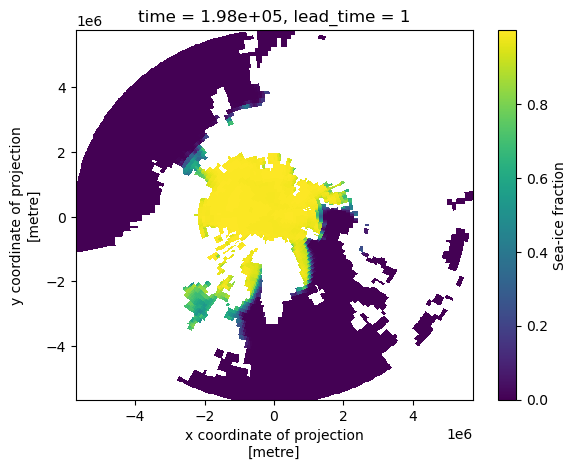

: 

In [78]:
ds[0,0,0].plot()